# Simulation for Salt intrusion


First the nessecary python packages are imported. This is a combination of open source packages (numpy, pygimli, ..) and code developed by Deltares (ert_inversion)

In [2]:
import os
import subprocess
from importlib import resources
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
from pygimli.meshtools import readGmsh
from pygimli.physics import ert

from ertoolbox import MPT, inversion


Set the data folder belonging to the ERToolbox package


In [16]:
data_folder = Path(resources.files("ertoolbox.data"))
figsize = (12, 4)
cmin = 0
cmax = 2.7

## Mesh

To be able to simulate for the real geometry of the field measurements, the inversion mesh is created using GMSH and imported using Pygimli. The input file is .geo file and is rewritten into a .msh. After importing the mesh, the prior resistivity values are set in the K value per mesh domain. 

Creating a working mesh is very important, some key aspects that are vital for the inversion to work are:
- mesh should consists of points, lines, line loops and a plane surface, that are also made 'physical'
- line loop should be a closed loop
- electrode positions should be a point defined in the input file
- if you cannot make the mesh in gmsh already, the geometry is corrupt

We use 2 files. 1 file only has 1 fixed conductivity in the inversion domain. The other one has a fresh-salt interface and uses 6 different conductivities. 


The .geo file in imported, translated to .msh and filled with K values in this part of the code:

Reading C:\Users\nieboer\gitclones\SaltSimulator\ertoolbox\data\kornwerderzand_1l.msh... 

  Nodes: 736
  Entries: 1599
    Points: 129
    Lines: 237
    Triangles: 1233
    Quads: 0
    Tetrahedra: 0 

Creating mesh object... 

  Dimension: 2-D
  Boundary types: 1 (-1,)
  Regions: 1 (2,)
  Marked nodes: 129 (999,)

Done. 

  Mesh: Nodes: 736 Cells: 1233 Boundaries: 1968


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x2239a05e310>)

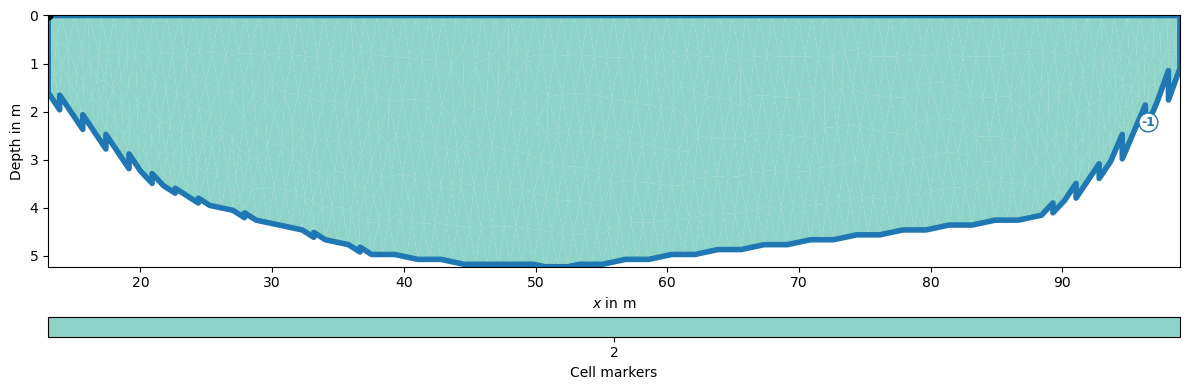

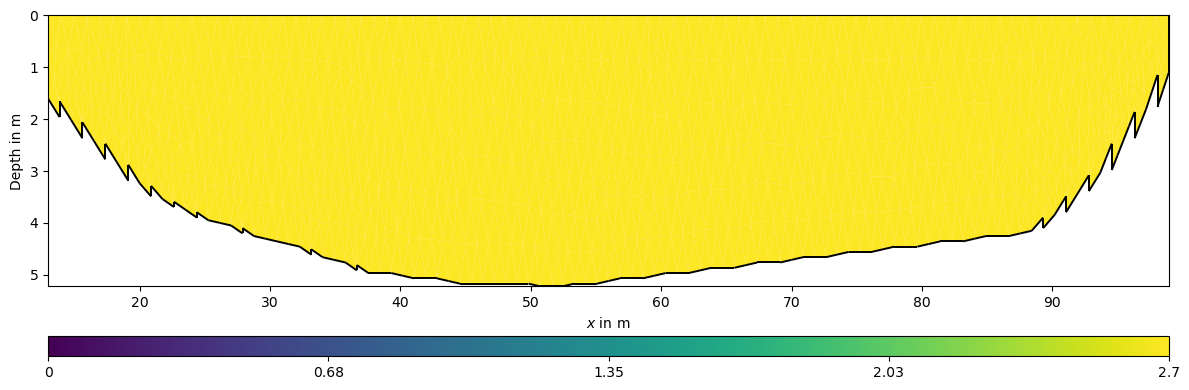

In [17]:
filename_1l = data_folder / "kornwerderzand_1l.geo"
meshname_1l = filename_1l.with_suffix(".msh")

geom_1l = subprocess.call(["gmsh", "-format", "msh2", "-2", "-o", meshname_1l, filename_1l], shell=True)
mesh_1l = readGmsh(meshname_1l, verbose=True)
mesh = mesh_1l
K_1l= [[2,100]]

pg.show(mesh_1l, markers=True, clipBoundaryMarkers=True, figsize=(12,4), aspect='auto')
pg.show(mesh_1l, data = K_1l, clipBoundaryMarkers=True, showmesh=True, figsize=(12,4), aspect='auto', cMin = cmin, cMax = cmax)

Reading C:\Users\nieboer\gitclones\SaltSimulator\ertoolbox\data\kornwerderzand_6l.msh... 

  Nodes: 1090
  Entries: 1941
    Points: 0
    Lines: 0
    Triangles: 1941
    Quads: 0
    Tetrahedra: 0 

Creating mesh object... 

  Dimension: 2-D
  Regions: 6 (100, 200, 300, 400, 500, 600)

Done. 

  Mesh: Nodes: 1090 Cells: 1941 Boundaries: 3030


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x2239c5f9050>)

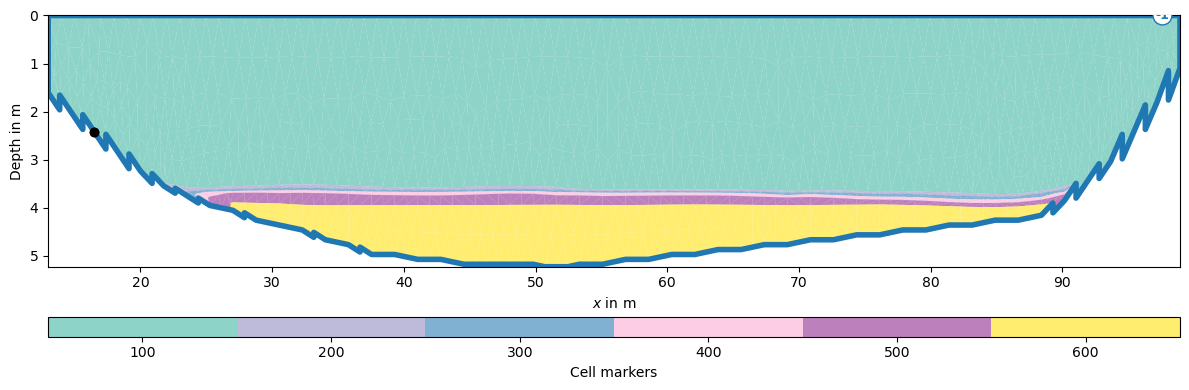

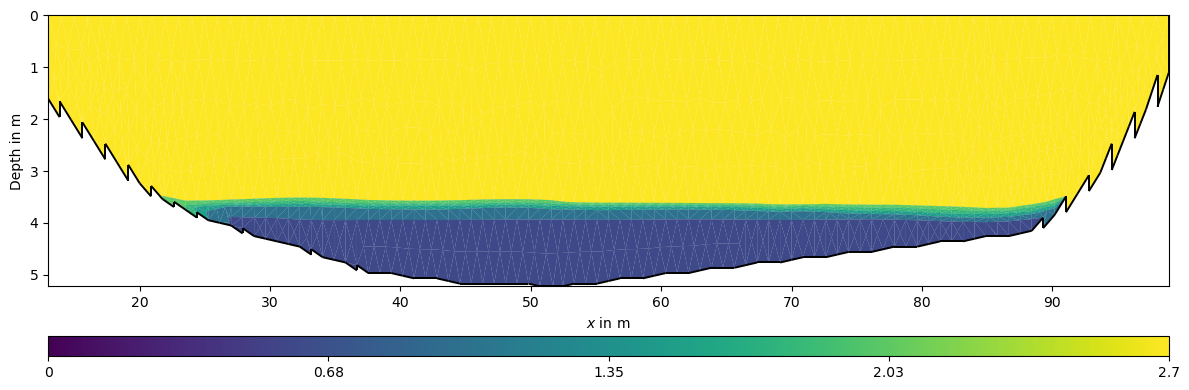

In [19]:
import pygimli.meshtools as mt

filename_6l = data_folder / "kornwerderzand_6l.geo"
meshname_6l = filename_6l.with_suffix(".msh")

geom_6l = subprocess.call(["gmsh", "-format", "msh2", "-2", "-o", meshname_6l, filename_6l], shell=True)
mesh_6l = readGmsh(meshname_6l, verbose=True)

mesh_6l = mt.appendTriangleBoundary(mesh_6l, xbound=100., ybound=100., quality=31, smooth=True,
                                 marker=3, isSubSurface=True, addNodes=5)

K_6l= [[100,2.7],[200,2],[300,1.8],[400,1.5],[500,1],[600,0.6] ]
# K_6l= [[1,100],[3,100]]
pg.show(mesh_6l, markers=True, clipBoundaryMarkers=True, figsize=(12,4), aspect='auto')
pg.show(mesh_6l, data =K_6l, clipBoundaryMarkers=True, showmesh=True, figsize=(12,4), aspect='auto', cMin = cmin, cMax = cmax)

for the inversion, we use a clean mesh.

Reading C:\Users\nieboer\gitclones\SaltSimulator\ertoolbox\data\kornwerderzand_1l.msh... 

  Nodes: 736
  Entries: 1599
    Points: 129
    Lines: 237
    Triangles: 1233
    Quads: 0
    Tetrahedra: 0 

Creating mesh object... 

  Dimension: 2-D
  Boundary types: 1 (-1,)
  Regions: 1 (2,)
  Marked nodes: 129 (999,)

Done. 

  Mesh: Nodes: 736 Cells: 1233 Boundaries: 1968


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

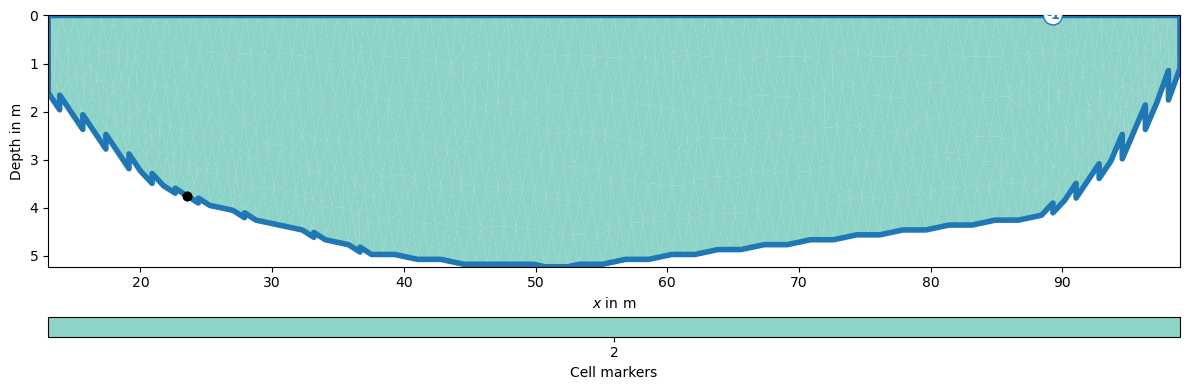

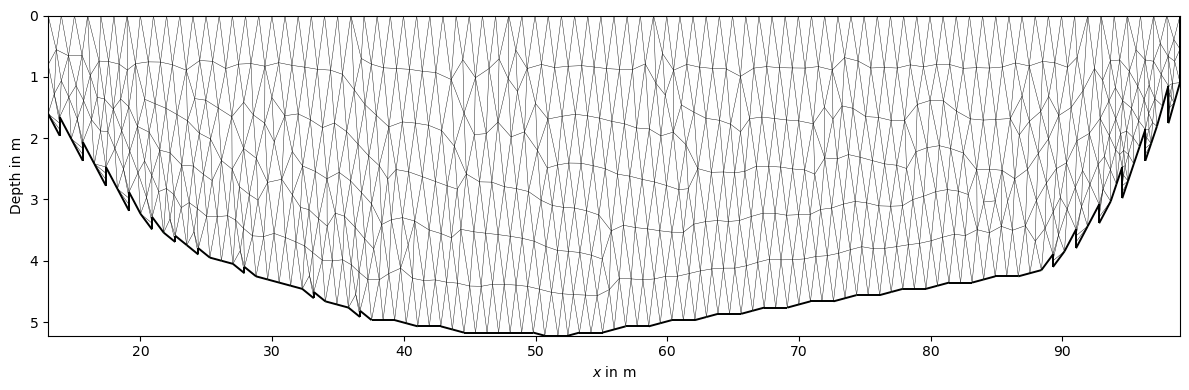

In [50]:
filename = data_folder / "kornwerderzand_1l.geo"
inversion_mesh = filename.with_suffix(".msh")

geom = subprocess.call(["gmsh", "-format", "msh2", "-2", "-o", inversion_mesh, filename])
mesh = readGmsh(inversion_mesh, verbose=True)
mesh = mt.appendTriangleBoundary(mesh, xbound=100., ybound=100., quality=31, smooth=True,
                                 marker=3, isSubSurface=True, addNodes=5)

pg.show(mesh, markers=True, clipBoundaryMarkers=True, figsize=(12,4), aspect='auto')
pg.show(mesh,clipBoundaryMarkers=True, showmesh=True, figsize=(12,4), aspect='auto')

## Simulate data

Using the custom mesh, we can make simulation data. This consists of the electrode positions and the inversion scheme. 3 schemes are shown here: dipole-dipole (dd), multiple gradient(gr) and one costom made mesh that was used in the field test.

Other possible standard configurations are: 
Wenner Alpha (C-P-P-C) :  wa
Wenner Beta(C-C-P-P) :  wb
Dipole Dipole (CC-PP) :  dd
Schlumberger(C-PP-C) :  slm
Pole Pole (C-P) :  pp
Pole Dipole (C-PP) :  pd
Half Wenner (C-P-P) :  hw
MultipleGradient(C--P-P--C) :  gr


first, the electrode positions are defined:

In [29]:

points =[(12.99, -1.6041734693877547), (13.867040816326531, -1.6551428571428568), (14.744081632653062, -2.0119285714285713),  (15.621122448979591, -2.0628979591836734), (16.498163265306122, -2.419683673469388), (17.375204081632653, -2.4706530612244895), (18.252244897959184, -2.827438775510204), (19.129285714285714, -2.878408163265306), (20.883367346938776, -3.286163265306122), (21.760408163265307, -3.5410102040816325), (22.637448979591838, -3.5919795918367345), (23.514489795918365, -3.7448877551020407), (24.391530612244896, -3.795857142857143), (25.268571428571427, -3.948765306122449), (26.145612244897958, -3.999734693877551), (27.89969387755102, -4.101673469387755), (28.77673469387755, -4.254581632653061), (29.65377551020408, -4.3055510204081635), (30.530816326530612, -4.356520408163266), (31.407857142857143, -4.407489795918368), (32.284897959183674, -4.45845918367347), (33.16193877551021, -4.509428571428572), (34.038979591836735, -4.662336734693877), (35.7930612244898, -4.764275510204081), (36.67010204081633, -4.815244897959183), (37.54714285714286, -4.9681530612244895), (39.30122448979592, -4.9681530612244895), (40.178265306122455, -5.019122448979592), (41.05530612244898, -5.070091836734694), (42.809387755102044, -5.070091836734694), (43.68642857142858, -5.121061224489796), (44.563469387755106, -5.172030612244898), (46.31755102040817, -5.172030612244898), (48.07163265306123, -5.172030612244898), (49.82571428571429, -5.172030612244898), (50.702755102040825, -5.223), (52.45683673469388, -5.223), (53.333877551020414, -5.172030612244898), (55.08795918367347, -5.172030612244898), (55.965, -5.121061224489796), (56.84204081632653, -5.070091836734694), (58.59612244897959, -5.070091836734694), (59.47316326530613, -5.019122448979592), (60.350204081632654, -4.9681530612244895), (62.104285714285716, -4.9681530612244895), (62.98132653061225, -4.9171836734693875), (63.85836734693878, -4.866214285714285), (65.61244897959183, -4.866214285714285), (66.48948979591836, -4.815244897959183), (67.3665306122449, -4.764275510204081), (69.12061224489796, -4.764275510204081), (69.9976530612245, -4.713306122448979), (70.87469387755102, -4.662336734693877), (72.62877551020408, -4.662336734693877), (73.5058163265306, -4.611367346938775), (74.38285714285715, -4.560397959183673), (76.1369387755102, -4.560397959183673), (77.01397959183673, -4.509428571428572), (77.89102040816326, -4.45845918367347), (79.64510204081633, -4.45845918367347), (80.52214285714285, -4.407489795918368), (81.39918367346938, -4.356520408163266), (83.15326530612245, -4.356520408163266), (84.03030612244898, -4.3055510204081635), (84.9073469387755, -4.254581632653061), (86.66142857142857, -4.254581632653061), (87.5384693877551, -4.203612244897959), (88.41551020408163, -4.152642857142857), (89.29255102040815, -3.897795918367347), (90.1695918367347, -3.846826530612245), (91.04663265306122, -3.4900408163265304),  (91.92367346938775, -3.4390714285714283), (92.80071428571429, -3.0822857142857143), (93.67775510204082, -3.0313163265306122), (94.55479591836735, -2.4706530612244895), (95.43183673469387, -2.419683673469388), (96.3088775510204, -1.859020408163265), (97.18591836734693, -1.808051020408163), (98.06295918367346, -1.1454489795918361), (98.94, -1.0944795918367345)]

# Functie om de afstand tussen twee punten te berekenen
def distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Functie om nieuwe punten te genereren die 1 meter uit elkaar liggen
def generate_points(points):
    new_points = [points[0]]

    for i in range(1, len(points)):
        p1 = new_points[-1]
        p2 = points[i]

        while distance(p1, p2) > 1:
            dx = p2[0] - p1[0]
            dz = p2[1] - p1[1]
            dist = distance(p1, p2)

            new_x = p1[0] + dx / dist
            new_z = max(p1[1] + dz / dist, p2[1]) + 0.1

            new_points.append((new_x, new_z))
            p1 = new_points[-1]

    return new_points

def generate_points05(points):
    new_points = [points[0]]

    for i in range(1, len(points)):
        p1 = new_points[-1]
        p2 = points[i]

        while distance(p1, p2) > 0.5:  # Verander 1 naar 0.5
            dx = p2[0] - p1[0]
            dz = p2[1] - p1[1]
            dist = distance(p1, p2)

            new_x = p1[0] + dx / dist * 0.5  # Voeg de 0.5m afstand toe
            new_z = p1[1] + dz / dist * 0.5 +0.1  # Voeg de 0.5m afstand toe

            new_points.append((new_x, new_z))
            p1 = new_points[-1]

    return new_points
new_points = generate_points(points)
print(new_points)
electrodes = [[x, y] for x, y in new_points]

halfplus = int((len(electrodes)/2)+32)
halfmin = int((len(electrodes)/2)-32)
# print(halfplus)
# print(electrodes[halfmin:halfplus])
electrodes = electrodes[halfmin:halfplus]

print(electrodes)
print(len(electrodes))
# xelec = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
xelec = [24,25,26,24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
zelec = np.zeros(len(xelec))
electrodes = [[x, y] for x, y in zip(xelec,zelec)]

[(12.99, -1.6041734693877547), (13.964028955165732, -1.7305969542535062), (14.94450910837278, -1.827215033704722), (15.878876670361523, -2.0835256553583728), (16.84700065158283, -2.2339971247599797), (17.768222889727316, -2.5230338684591698), (18.735785544585408, -2.6756650401778663), (19.697674998277503, -2.8491036601201234), (20.63596019439743, -3.094966191687489), (21.565497802356482, -3.363693510162487), (22.543564458796737, -3.471985650100083), (23.506259485245717, -3.642574426752773), (24.49149936467066, -3.713753806324986), (25.476880675068593, -3.7841171624742875), (26.46840021131427, -3.8140748834575313), (27.44880399592125, -3.911073409158383), (28.416937144155977, -4.06150944348475), (29.39802190862642, -4.155088070724383), (30.38257742643212, -4.230160719525805), (31.367947819753155, -4.300587207978602), (32.36124008826816, -4.316217953493397), (33.34061613498691, -4.4182638866708785), (34.33080933243554, -4.457968688758898), (35.309565839715596, -4.562994783334552), (36.29

### Dipole Dipole

The scheme is built-in and data is created using the dipole-dipole scheme for both geometries. Next, the simulated data is inverted using a clean inversion mesh.

27/12/24 - 15:43:08 - pyGIMLi - INFO - Data error estimate (min:max)  0.010001756421173473 : 0.010237835728170672
27/12/24 - 15:43:08 - pyGIMLi - INFO - Found 1 regions.
27/12/24 - 15:43:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/12/24 - 15:43:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/12/24 - 15:43:08 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2704 Cells: 4932 Boundaries: 3936
27/12/24 - 15:43:08 - pyGIMLi - INFO - Use median(data values)=3.7001016949662993
27/12/24 - 15:43:08 - pyGIMLi - INFO - Created startmodel from forward operator: 1233, min/max=3.700102/3.700102
27/12/24 - 15:43:08 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000146D6948A90>
Data transformation: <pgcore.libs._pygimli_.RTransLogLU object at 0x00000146D5C4C900>
Model transformation: <pgcore.libs._pygimli_.RTransLog object at 0x000001468E66CEF0>
min/max (data): 2.56/13.25
min/max (error): 1%/1.02%
min/max (start model): 3.7/3.7
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 5077.63
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  118.99 (dPhi = 97.63%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.91 (dPhi = 97.02%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.54 (dPhi = 9.92%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.54 (dPhi = 0.00%) lam: 20.0
######

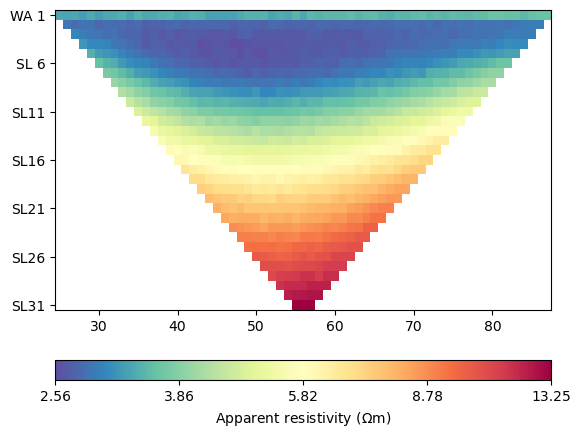

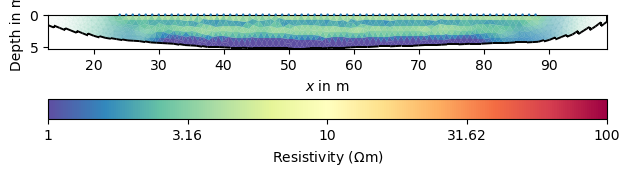

In [53]:
scheme_dd = ert.createData(elecs=electrodes, schemeName='slm')
scheme_gr = ert.createData(elecs=electrodes, schemeName='slm')
# print(scheme_dd['a'])
# print(scheme_gr['b'])
simdata_dd_2l = ert.simulate(
         mesh=mesh_6l, scheme=scheme_dd, res=K_6l, noiseLevel=0.01, noiseAbs=1e-6, seed=1337
    )
ert.show(simdata_dd_2l)
simdata_dd_2l.remove(simdata_dd_2l['rhoa'] < 0)
inversion_dd_2 = inversion(simdata_dd_2l, mesh, saveresult=False)


NameError: name 'inversion_dd_2' is not defined

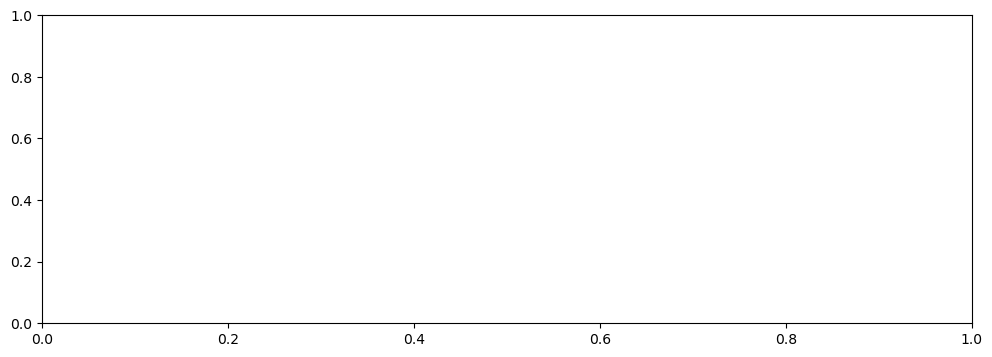

In [24]:

fig, ax = plt.subplots(figsize=figsize)
pg.show(mesh, data=inversion_dd_2, ax=ax, cMin=cmin, cMax=cmax, showMesh=True, showNodes=False, label='K [m/s]')
#inversion_dd_2.showResult(ax=ax, aspect='auto', cMin=cmin, cMax=cmax)

27/12/24 - 15:18:49 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000045896944148 : 0.010000217833377477
27/12/24 - 15:18:49 - pyGIMLi - INFO - Found 1 regions.
27/12/24 - 15:18:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/12/24 - 15:18:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/12/24 - 15:18:49 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2704 Cells: 4932 Boundaries: 3936
27/12/24 - 15:18:49 - pyGIMLi - INFO - Use median(data values)=204.45051164508163
27/12/24 - 15:18:49 - pyGIMLi - INFO - Created startmodel from forward operator: 1233, min/max=204.450512/204.450512
27/12/24 - 15:18:49 - pyGIMLi - INFO - Starting inversion.


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014692024EF0>
Data transformation: <pgcore.libs._pygimli_.RTransLogLU object at 0x00000146D2F1EFC0>
Model transformation: <pgcore.libs._pygimli_.RTransLog object at 0x00000146D19BD670>
min/max (data): 105/787
min/max (error): 1%/1%
min/max (start model): 204/204
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 4853.05
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    4.15 (dPhi = 99.90%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.33 (dPhi = 57.74%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.33 (dPhi = 0.62%) lam: 20.0
###############################################

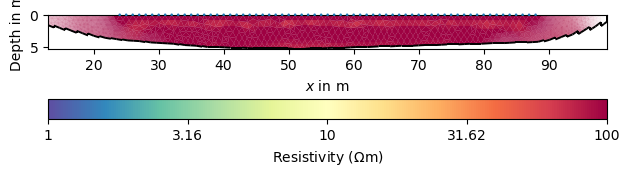

In [31]:
scheme_dd = ert.createData(elecs=electrodes, schemeName='wa')

simdata_dd_1l = ert.simulate(
         mesh=mesh_1l, scheme=scheme_dd, res=K_1l, noiseLevel=1, noiseAbs=1e-6, seed=1337
    )

# simdata_dd_2l = ert.simulate(
#          mesh=mesh_2l, scheme=scheme_dd, res=K_2l, noiseLevel=1, noiseAbs=1e-6, seed=1337
#     )

simdata_dd_1l.remove(simdata_dd_1l['rhoa'] < 0)
# simdata_dd_2l.remove(simdata_dd_2l['rhoa'] < 0)

inversion_dd_1 = inversion(simdata_dd_1l, mesh, saveresult=False)

# inversion_dd_2 = inversion(simdata_dd_2l, mesh, saveresult=False)



### Gradient
for the gradient based scheme, the workflow is the same as for dipole dipole.

27/12/24 - 15:19:04 - pyGIMLi - INFO - Data error estimate (min:max)  0.01000008893092331 : 0.010000672446930248


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


27/12/24 - 15:19:06 - pyGIMLi - INFO - Data error estimate (min:max)  0.01000366079125044 : 0.010048760630230873
27/12/24 - 15:19:06 - pyGIMLi - INFO - Found 1 regions.
27/12/24 - 15:19:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/12/24 - 15:19:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/12/24 - 15:19:06 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2704 Cells: 4932 Boundaries: 3936
27/12/24 - 15:19:06 - pyGIMLi - INFO - Use median(data values)=129.99442250523254
27/12/24 - 15:19:06 - pyGIMLi - INFO - Created startmodel from forward operator: 1233, min/max=129.994423/129.994423
27/12/24 - 15:19:06 - pyGIMLi - INFO - Starting inversion.


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014693B83560>
Data transformation: <pgcore.libs._pygimli_.RTransLogLU object at 0x000001469AB68270>
Model transformation: <pgcore.libs._pygimli_.RTransLog object at 0x00000146D19BFA60>
min/max (data): 109/850
min/max (error): 1%/1%
min/max (start model): 130/130
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  597.97
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    2.22 (dPhi = 99.56%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.06 (dPhi = 43.71%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.05 (dPhi = 0.16%) lam: 20.0
###############################################

27/12/24 - 15:19:19 - pyGIMLi - INFO - Found 1 regions.
27/12/24 - 15:19:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/12/24 - 15:19:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/12/24 - 15:19:19 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2704 Cells: 4932 Boundaries: 3936
27/12/24 - 15:19:19 - pyGIMLi - INFO - Use median(data values)=3.129421656438893
27/12/24 - 15:19:19 - pyGIMLi - INFO - Created startmodel from forward operator: 1233, min/max=3.129422/3.129422
27/12/24 - 15:19:19 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000146D2D84EF0>
Data transformation: <pgcore.libs._pygimli_.RTransLogLU object at 0x00000146D1A00450>
Model transformation: <pgcore.libs._pygimli_.RTransLog object at 0x00000146D2DB81D0>
min/max (data): 2.5/12.27
min/max (error): 1%/1%
min/max (start model): 3.13/3.13
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 2514.20
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   50.56 (dPhi = 97.95%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.49 (dPhi = 94.08%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.28 (dPhi = 5.22%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.27 (dPhi = 0.06%) lam: 20.0
########

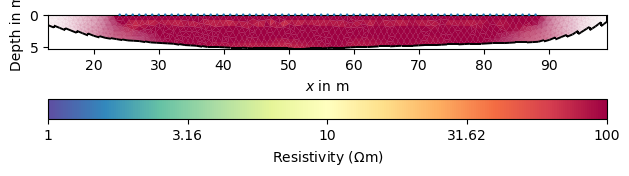

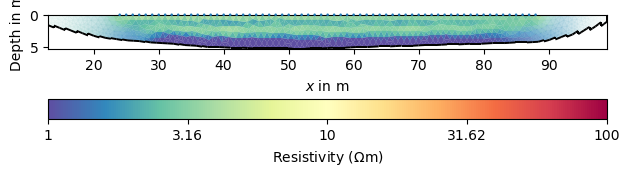

In [32]:
scheme_gr = ert.createData(elecs=electrodes, schemeName = 'gr')

simdata_gr_1l = ert.simulate(mesh=mesh_1l, scheme=scheme_gr, res=K_1l, noiseLevel=1, noiseAbs=1e-6, seed=1337)
simdata_gr_6l = ert.simulate(mesh=mesh_6l, scheme=scheme_gr, res=K_6l, noiseLevel=1, noiseAbs=1e-6, seed=1337)

simdata_gr_1l.remove(simdata_gr_1l['rhoa'] < 0)
simdata_gr_6l.remove(simdata_gr_6l['rhoa'] < 0)

inversion_gr_1 = inversion(simdata_gr_1l, mesh, saveresult=False)
inversion_gr_6 = inversion(simdata_gr_6l, mesh, saveresult=False)

### Customized

For the customized scheme, this scheme should be created first and written down in a datacontainer for Pygimli to be able to handle the scheme.

In [33]:
#datacontainer for custom abmn

import pygimli as pg
from pygimli.physics import ert


def prepare_custom_scheme(EX,EZ):
    dc = pg.DataContainerERT()

    for s in range(len(EX)):
        dc.createSensor(
            [
                EX[s],
                0,
                EZ[s],
            ]
        )

    A = [2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,78,78,78,78,78,78,78,78,78,78,78,78,78,78,79,79,79,79,79,79,79,79,79,79,79,79,79,80,80,80,80,80,80,80,80,80,80,80,80,80,81,81,81,81,81,81,81,81,81,81,81,81,81,82,82,82,82,82,82,82,82,82,82,82,82,83,83,83,83,83,83,83,83,83,83,83,84,84,84,84,84,84,84,84,84,84,85,85,85,85,85,85,85,85,85,86,86,86,86,86,86,86,86,87,87,87,87,87,87,87,88,88,88,88,88,88,88,89,89,89,89,89,89,90,90,90,90,90,91,91,91,91,92,92,92,93,93,94
]
    B = [1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,3,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,4,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,5,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,6,6,6,4,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7,7,5,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7,8,8,8,8,8,8,8,6,6,6,6,6,6,7,7,7,7,7,7,8,8,8,8,8,8,9,9,9,9,9,9,9,7,7,7,7,7,7,8,8,8,8,8,8,9,9,9,9,9,9,10,10,10,10,10,10,10,8,8,8,8,8,8,9,9,9,9,9,9,10,10,10,10,10,10,11,11,11,11,11,11,11,9,9,9,9,9,9,10,10,10,10,10,10,11,11,11,11,11,11,12,12,12,12,12,12,12,10,10,10,10,10,10,11,11,11,11,11,11,12,12,12,12,12,12,13,13,13,13,13,13,13,11,11,11,11,11,11,12,12,12,12,12,12,13,13,13,13,13,13,14,14,14,14,14,14,14,12,12,12,12,12,12,13,13,13,13,13,13,14,14,14,14,14,14,15,15,15,15,15,15,15,13,13,13,13,13,13,14,14,14,14,14,14,15,15,15,15,15,15,16,16,16,16,16,16,16,14,14,14,14,14,14,15,15,15,15,15,15,16,16,16,16,16,16,17,17,17,17,17,17,17,15,15,15,15,15,15,16,16,16,16,16,16,17,17,17,17,17,17,18,18,18,18,18,18,18,16,16,16,16,16,16,17,17,17,17,17,17,18,18,18,18,18,18,19,19,19,19,19,19,19,17,17,17,17,17,17,18,18,18,18,18,18,19,19,19,19,19,19,20,20,20,20,20,20,20,18,18,18,18,18,18,19,19,19,19,19,19,20,20,20,20,20,20,21,21,21,21,21,21,21,19,19,19,19,19,19,20,20,20,20,20,20,21,21,21,21,21,21,22,22,22,22,22,22,22,20,20,20,20,20,20,21,21,21,21,21,21,22,22,22,22,22,22,23,23,23,23,23,23,23,21,21,21,21,21,21,22,22,22,22,22,22,23,23,23,23,23,23,24,24,24,24,24,24,24,22,22,22,22,22,22,23,23,23,23,23,23,24,24,24,24,24,24,25,25,25,25,25,25,25,23,23,23,23,23,23,24,24,24,24,24,24,25,25,25,25,25,25,26,26,26,26,26,26,26,24,24,24,24,24,24,25,25,25,25,25,25,26,26,26,26,26,26,27,27,27,27,27,27,27,25,25,25,25,25,25,26,26,26,26,26,26,27,27,27,27,27,27,28,28,28,28,28,28,28,26,26,26,26,26,26,27,27,27,27,27,27,28,28,28,28,28,28,29,29,29,29,29,29,29,27,27,27,27,27,27,28,28,28,28,28,28,29,29,29,29,29,29,30,30,30,30,30,30,30,28,28,28,28,28,28,29,29,29,29,29,29,30,30,30,30,30,30,31,31,31,31,31,31,31,29,29,29,29,29,29,30,30,30,30,30,30,31,31,31,31,31,31,32,32,32,32,32,32,32,30,30,30,30,30,30,31,31,31,31,31,31,32,32,32,32,32,32,33,33,33,33,33,33,33,31,31,31,31,31,31,32,32,32,32,32,32,33,33,33,33,33,33,34,34,34,34,34,34,34,32,32,32,32,32,32,33,33,33,33,33,33,34,34,34,34,34,34,35,35,35,35,35,35,35,33,33,33,33,33,33,34,34,34,34,34,34,35,35,35,35,35,35,36,36,36,36,36,36,36,34,34,34,34,34,34,35,35,35,35,35,35,36,36,36,36,36,36,37,37,37,37,37,37,37,35,35,35,35,35,35,36,36,36,36,36,36,37,37,37,37,37,37,38,38,38,38,38,38,38,36,36,36,36,36,36,37,37,37,37,37,37,38,38,38,38,38,38,39,39,39,39,39,39,39,37,37,37,37,37,37,38,38,38,38,38,38,39,39,39,39,39,39,40,40,40,40,40,40,40,38,38,38,38,38,38,39,39,39,39,39,39,40,40,40,40,40,40,41,41,41,41,41,41,41,39,39,39,39,39,39,40,40,40,40,40,40,41,41,41,41,41,41,42,42,42,42,42,42,42,40,40,40,40,40,40,41,41,41,41,41,41,42,42,42,42,42,42,43,43,43,43,43,43,43,41,41,41,41,41,41,42,42,42,42,42,42,43,43,43,43,43,43,44,44,44,44,44,44,44,42,42,42,42,42,42,43,43,43,43,43,43,44,44,44,44,44,44,45,45,45,45,45,45,45,43,43,43,43,43,43,44,44,44,44,44,44,45,45,45,45,45,45,46,46,46,46,46,46,46,44,44,44,44,44,44,45,45,45,45,45,45,46,46,46,46,46,46,47,47,47,47,47,47,47,45,45,45,45,45,45,46,46,46,46,46,46,47,47,47,47,47,47,48,48,48,48,48,48,48,46,46,46,46,46,46,47,47,47,47,47,47,48,48,48,48,48,48,49,49,49,49,49,49,49,47,47,47,47,47,47,48,48,48,48,48,48,49,49,49,49,49,49,50,50,50,50,50,50,50,48,48,48,48,48,48,49,49,49,49,49,49,50,50,50,50,50,50,51,51,51,51,51,51,51,49,49,49,49,49,49,50,50,50,50,50,50,51,51,51,51,51,51,52,52,52,52,52,52,52,50,50,50,50,50,50,51,51,51,51,51,51,52,52,52,52,52,52,53,53,53,53,53,53,53,51,51,51,51,51,51,52,52,52,52,52,52,53,53,53,53,53,53,54,54,54,54,54,54,54,52,52,52,52,52,52,53,53,53,53,53,53,54,54,54,54,54,54,55,55,55,55,55,55,55,53,53,53,53,53,53,54,54,54,54,54,54,55,55,55,55,55,55,56,56,56,56,56,56,56,54,54,54,54,54,54,55,55,55,55,55,55,56,56,56,56,56,56,57,57,57,57,57,57,57,55,55,55,55,55,55,56,56,56,56,56,56,57,57,57,57,57,57,58,58,58,58,58,58,58,56,56,56,56,56,56,57,57,57,57,57,57,58,58,58,58,58,58,59,59,59,59,59,59,59,57,57,57,57,57,57,58,58,58,58,58,58,59,59,59,59,59,59,60,60,60,60,60,60,60,58,58,58,58,58,58,59,59,59,59,59,59,60,60,60,60,60,60,61,61,61,61,61,61,61,59,59,59,59,59,59,60,60,60,60,60,60,61,61,61,61,61,61,62,62,62,62,62,62,62,60,60,60,60,60,60,61,61,61,61,61,61,62,62,62,62,62,62,63,63,63,63,63,63,63,61,61,61,61,61,61,62,62,62,62,62,62,63,63,63,63,63,63,64,64,64,64,64,64,64,62,62,62,62,62,63,63,63,63,63,63,64,64,64,64,64,64,65,65,65,65,65,65,65,63,63,63,63,64,64,64,64,64,64,65,65,65,65,65,65,66,66,66,66,66,66,66,64,64,64,65,65,65,65,65,65,66,66,66,66,66,66,67,67,67,67,67,67,67,65,65,66,66,66,66,66,66,67,67,67,67,67,67,68,68,68,68,68,68,68,66,67,67,67,67,67,67,68,68,68,68,68,68,69,69,69,69,69,69,69,68,68,68,68,68,68,69,69,69,69,69,69,70,70,70,70,70,70,70,69,69,69,69,69,69,70,70,70,70,70,70,71,71,71,71,71,71,71,70,70,70,70,70,70,71,71,71,71,71,71,72,72,72,72,72,72,72,71,71,71,71,71,72,72,72,72,72,72,73,73,73,73,73,73,73,72,72,72,72,73,73,73,73,73,73,74,74,74,74,74,74,74,73,73,73,74,74,74,74,74,74,75,75,75,75,75,75,75,74,74,75,75,75,75,75,75,76,76,76,76,76,76,76,75,76,76,76,76,76,76,77,77,77,77,77,77,77,77,77,77,77,77,77,78,78,78,78,78,78,78,78,78,78,78,78,78,79,79,79,79,79,79,79,79,79,79,79,79,79,80,80,80,80,80,80,80,80,80,80,80,80,81,81,81,81,81,81,81,81,81,81,81,82,82,82,82,82,82,82,82,82,82,83,83,83,83,83,83,83,83,83,84,84,84,84,84,84,84,84,85,85,85,85,85,85,85,86,86,86,86,86,86,86,87,87,87,87,87,87,87,88,88,88,88,88,88,89,89,89,89,89,90,90,90,90,91,91,91,92,92,93
]
    M = [3,4,5,6,7,8,9,11,12,13,14,15,16,4,5,6,7,8,9,10,19,20,21,22,23,24,12,13,14,15,16,17,5,6,7,8,9,10,11,27,28,29,30,31,32,20,21,22,23,24,25,13,14,15,16,17,18,6,7,8,9,10,11,12,28,29,30,31,32,33,21,22,23,24,25,26,14,15,16,17,18,19,7,8,9,10,11,12,13,29,30,31,32,33,34,22,23,24,25,26,27,15,16,17,18,19,20,8,9,10,11,12,13,14,30,31,32,33,34,35,23,24,25,26,27,28,16,17,18,19,20,21,9,10,11,12,13,14,15,31,32,33,34,35,36,24,25,26,27,28,29,17,18,19,20,21,22,10,11,12,13,14,15,16,32,33,34,35,36,37,25,26,27,28,29,30,18,19,20,21,22,23,11,12,13,14,15,16,17,33,34,35,36,37,38,26,27,28,29,30,31,19,20,21,22,23,24,1,1,1,1,1,1,1,34,35,36,37,38,39,27,28,29,30,31,32,2,2,2,2,2,2,1,1,1,1,1,1,1,35,36,37,38,39,40,2,2,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,2,3,3,3,3,4,4,2,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,2,2,3,3,3,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,2,2,2,3,3,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,1,1,1,2,2,2,2,3,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,3,1,1,2,2,2,2,2,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,3,3,1,2,2,2,2,2,2,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,3,3,3,2,2,2,2,2,2,2,4,4,4,4,4,4,3,3,3,3,3,4,2,2,3,3,3,3,2,2,2,2,2,2,2,4,4,4,4,4,4,3,3,3,3,4,4,2,3,3,3,3,3,2,2,2,2,2,2,2,4,4,4,4,4,4,3,3,3,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,4,4,4,4,4,5,3,3,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,3,4,4,4,4,5,5,3,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,3,3,4,4,4,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,3,3,3,4,4,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,3,3,3,3,4,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,4,2,2,3,3,3,3,3,5,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,4,4,2,3,3,3,3,3,3,5,5,5,5,5,5,4,4,4,4,4,4,3,3,3,4,4,4,3,3,3,3,3,3,3,5,5,5,5,5,5,4,4,4,4,4,5,3,3,4,4,4,4,3,3,3,3,3,3,3,5,5,5,5,5,5,4,4,4,4,5,5,3,4,4,4,4,4,3,3,3,3,3,3,3,5,5,5,5,5,5,4,4,4,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,3,5,5,5,5,5,6,4,4,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,4,5,5,5,5,6,6,4,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,4,4,5,5,5,6,6,6,5,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,4,4,4,5,5,6,6,6,6,5,5,5,5,5,5,4,4,4,4,4,4,3,3,3,4,4,4,4,5,6,6,6,6,6,5,5,5,5,5,5,4,4,4,4,4,5,3,3,4,4,4,4,4,6,6,6,6,6,6,5,5,5,5,5,5,4,4,4,4,5,5,3,4,4,4,4,4,4,6,6,6,6,6,6,5,5,5,5,5,5,4,4,4,5,5,5,4,4,4,4,4,4,4,6,6,6,6,6,6,5,5,5,5,5,6,4,4,5,5,5,5,4,4,4,4,4,4,4,6,6,6,6,6,6,5,5,5,5,6,6,4,5,5,5,5,5,4,4,4,4,4,4,4,6,6,6,6,6,6,5,5,5,6,6,6,5,5,5,5,5,5,4,4,4,4,4,4,4,6,6,6,6,6,7,5,5,6,6,6,6,5,5,5,5,5,5,4,4,4,4,4,4,5,6,6,6,6,7,7,5,6,6,6,6,6,5,5,5,5,5,5,4,4,4,4,4,5,5,6,6,6,7,7,7,6,6,6,6,6,6,5,5,5,5,5,5,4,4,4,4,5,5,5,6,6,7,7,7,7,6,6,6,6,6,6,5,5,5,5,5,5,4,4,4,5,5,5,5,6,7,7,7,7,7,6,6,6,6,6,6,5,5,5,5,5,6,4,4,5,5,5,5,5,7,7,7,7,7,7,6,6,6,6,6,6,5,5,5,5,6,6,4,5,5,5,5,5,5,7,7,7,7,7,7,6,6,6,6,6,6,5,5,5,6,6,6,5,5,5,5,5,5,5,7,7,7,7,7,7,6,6,6,6,6,7,5,5,6,6,6,6,5,5,5,5,5,5,5,7,7,7,7,7,7,6,6,6,6,7,7,5,6,6,6,6,6,5,5,5,5,5,5,5,7,7,7,7,7,7,6,6,6,7,7,7,6,6,6,6,6,6,5,5,5,5,5,5,5,7,7,7,7,7,8,6,6,7,7,7,7,6,6,6,6,6,6,5,5,5,5,5,5,6,7,7,7,7,8,8,6,7,7,7,7,7,6,6,6,6,6,6,5,5,5,5,5,6,6,7,7,7,8,8,8,7,7,7,7,7,7,6,6,6,6,6,6,5,5,5,5,6,6,6,7,7,8,8,8,8,7,7,7,7,7,7,6,6,6,6,6,6,5,5,5,6,6,6,6,7,8,8,8,8,8,7,7,7,7,7,7,6,6,6,6,6,7,5,5,6,6,6,6,6,8,8,8,8,8,8,7,7,7,7,7,7,6,6,6,6,7,7,5,6,6,6,6,6,6,8,8,8,8,8,8,7,7,7,7,7,7,6,6,6,7,7,7,6,6,6,6,6,6,6,8,8,8,8,8,8,7,7,7,7,7,8,6,6,7,7,7,7,6,6,6,6,6,6,6,8,8,8,8,8,8,7,7,7,7,8,8,6,7,7,7,7,7,6,6,6,6,6,6,6,8,8,8,8,8,8,7,7,7,8,8,8,7,7,7,7,7,7,6,6,6,6,6,6,6,8,8,8,8,8,9,7,7,8,8,8,8,7,7,7,7,7,7,6,6,6,6,6,6,7,8,8,8,8,9,9,7,8,8,8,8,8,7,7,7,7,7,7,6,6,6,6,6,7,7,8,8,8,9,9,9,8,8,8,8,8,8,7,7,7,7,7,7,6,6,6,6,7,7,7,8,8,9,9,9,8,8,8,8,8,8,7,7,7,7,7,7,6,6,6,7,7,7,7,8,9,9,9,8,8,8,8,8,8,7,7,7,7,7,8,6,6,7,7,7,7,7,9,9,9,8,8,8,8,8,8,7,7,7,7,8,8,6,7,7,7,7,7,7,9,9,8,8,8,8,8,8,7,7,7,8,8,8,7,7,7,7,7,7,7,9,8,8,8,8,8,9,7,7,8,8,8,8,7,7,7,7,7,7,7,8,8,8,8,9,9,7,8,8,8,8,8,7,7,7,7,7,7,7,8,8,8,9,9,9,8,8,8,8,8,8,7,7,7,7,7,7,7,8,8,9,9,9,9,8,8,8,8,8,8,7,7,7,7,7,7,8,8,9,9,9,9,8,8,8,8,8,8,7,7,7,7,7,8,8,9,9,9,9,8,8,8,8,8,8,7,7,7,7,8,8,8,9,9,9,8,8,8,8,8,8,7,7,7,8,8,8,8,9,9,8,8,8,8,8,9,7,7,8,8,8,8,8,9,8,8,8,8,9,9,7,8,8,8,8,8,8,8,8,8,9,9,9,8,8,8,8,8,8,8,8,8,9,9,9,9,8,8,8,8,8,8,8,8,9,9,9,9,9,8,8,8,8,8,8,8,9,9,9,9,9,8,8,8,8,8,8,8,9,9,9,9,8,8,8,8,8,8,9,9,9,9,8,8,8,8,8,9,9,9,9,8,8,8,8,9,9,9,9,8,8,8,9,9,9,9,8,8,9,9,9,9,9,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
]
    N = [4,5,6,7,8,9,10,13,14,15,16,17,18,5,6,7,8,9,10,11,22,23,24,25,26,27,14,15,16,17,18,19,6,7,8,9,10,11,12,30,31,32,33,34,35,23,24,25,26,27,28,15,16,17,18,19,20,7,8,9,10,11,12,13,31,32,33,34,35,36,24,25,26,27,28,29,16,17,18,19,20,21,8,9,10,11,12,13,14,32,33,34,35,36,37,25,26,27,28,29,30,17,18,19,20,21,22,9,10,11,12,13,14,15,33,34,35,36,37,38,26,27,28,29,30,31,18,19,20,21,22,23,10,11,12,13,14,15,16,34,35,36,37,38,39,27,28,29,30,31,32,19,20,21,22,23,24,11,12,13,14,15,16,17,3,3,3,3,3,4,2,2,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,3,3,3,3,4,4,2,3,3,3,3,3,2,2,2,2,2,2,2,3,4,5,6,7,8,3,3,3,4,4,4,3,3,3,3,3,3,0,1,2,3,4,5,3,4,5,6,7,8,9,3,3,4,4,4,4,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,9,0,1,2,3,2,3,4,5,6,7,5,6,7,8,9,0,1,0,1,2,3,3,4,5,6,7,8,6,7,8,9,0,1,2,1,2,3,4,5,6,7,8,9,7,8,9,0,1,2,3,2,3,5,6,7,8,9,0,8,9,0,1,2,3,4,3,6,7,8,9,0,1,9,0,1,2,3,4,5,7,8,9,0,1,2,0,1,2,3,4,5,6,8,9,0,1,2,3,1,2,3,4,5,6,7,9,0,1,2,3,4,2,3,4,5,6,7,8,0,1,2,3,4,3,4,5,6,7,8,9,1,2,3,4,4,5,6,7,8,9,0,2,3,4,5,6,7,8,9,0,1,3,4,6,7,8,9,0,1,2,4,7,8,9,0,1,2,3,8,9,0,1,2,3,4,9,0,1,2,3,4,5,0,1,2,3,4,5,1,2,3,4,5,2,3,4,5,3,4,5,4,5,5
]

    for i in range(len(A)):
        dc.addFourPointData(
            A[i]-1,
            B[i]-1,
            M[i]-1,
            N[i]-1,
        )
    k = ert.createGeometricFactors(dc)
    dc.set("k", k)

    return dc

dc = prepare_custom_scheme(EX,EZ)


NameError: name 'EX' is not defined

then, a similar approach of making the data and inverting the data is carried out.

In [ ]:
simdata_c_1l = ert.simulate(mesh=mesh_1l, scheme=dc, res=K_1l, noiseLevel=1, noiseAbs=1e-6, seed=1337)
simdata_c_6l = ert.simulate(mesh=mesh_6l, scheme=dc, res=K_6l, noiseLevel=1, noiseAbs=1e-6, seed=1337)

simdata_c_1l.remove(simdata_c_1l['rhoa'] < 0)
simdata_c_6l.remove(simdata_c_6l['rhoa'] < 0)

inversion_c_1 = inversion(simdata_c_1l, mesh, saveresult=False)
inversion_c_6 = inversion(simdata_c_6l, mesh, saveresult=False)